## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [12]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [13]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [14]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2, 0.6, 0.9]
redice_lr_patient = [5, 10, 20]

In [15]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s-%s" % (reduce_factor, reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_35 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 6s 122us/step - loss: 1.4072 - acc: 0.5089 - val_loss: 1.5570 - val_acc: 0.4565
Epoch 8/10
50000/50000 [==============================] - 6s 118us/step - loss: 1.3703 - acc: 0.5224 - val_loss: 1.5512 - val_acc: 0.4559
Epoch 9/10
50000/50000 [==============================] - 6s 114us/step - loss: 1.3384 - acc: 0.5347 - val_loss: 1.5299 - val_acc: 0.4655
Epoch 10/10
50000/50000 [==============================] - 6s 111us/step - loss: 1.3082 - acc: 0.5456 - val_loss: 1.5148 - val_acc: 0.4686
Numbers of exp: 3, reduce_factor: 0.60, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batc

50000/50000 [==============================] - 7s 133us/step - loss: 1.6228 - acc: 0.4300 - val_loss: 1.6859 - val_acc: 0.4101
Epoch 4/10
50000/50000 [==============================] - 7s 140us/step - loss: 1.5493 - acc: 0.4553 - val_loss: 1.6344 - val_acc: 0.4280
Epoch 5/10
50000/50000 [==============================] - 7s 144us/step - loss: 1.4955 - acc: 0.4762 - val_loss: 1.5812 - val_acc: 0.4436
Epoch 6/10
50000/50000 [==============================] - 7s 134us/step - loss: 1.4502 - acc: 0.4914 - val_loss: 1.5574 - val_acc: 0.4441
Epoch 7/10
50000/50000 [==============================] - 7s 131us/step - loss: 1.4112 - acc: 0.5051 - val_loss: 1.5387 - val_acc: 0.4542
Epoch 8/10
50000/50000 [==============================] - 6s 126us/step - loss: 1.3765 - acc: 0.5197 - val_loss: 1.5294 - val_acc: 0.4589
Epoch 9/10
50000/50000 [==============================] - 6s 120us/step - loss: 1.3457 - acc: 0.5296 - val_loss: 1.5139 - val_acc: 0.4675
Epoch 10/10
50000/50000 [====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 187us/step - loss: 2.1893 - acc: 0.2678 - val_loss: 2.1219 - val_acc: 0.3125
Epoch 2/10
50000/50000 [==============================] - 7s 138us/step - loss: 1.7282 - acc: 0.3946 - val_loss: 1.7704 - val_acc: 0.3863
Epoch 3/10
50000/50000 [==============================] - 8s 153us/step - loss: 1.6135 - acc: 0.4323 - val_loss: 1.6630 - val_acc: 0.4210
Epoch 4/10
50000/50000 [==============================] - 6s 130us/step - loss: 1.5433 - acc: 0.4600 - val_loss: 1.6145 - val_acc: 0.4386
Epoch 5/10
50000/50000 [==============================] - 6s 128us/step - loss: 1.4909 - acc: 0.4799 - val_loss: 1.5723 - val_acc: 0.4479
Epoch 6/10
50000/50000 [==============================] - 9s 189us/step - loss: 1.4490 - acc: 0.4935 - val_loss: 1.5604 - val_acc: 0.4524
Epoch 7/10
50000/50000 [==============================] - 7s 139us/step - loss: 1.4095 - acc: 0.5094 - val_loss: 1.5330 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 176us/step - loss: 1.8003 - acc: 0.3621 - val_loss: 1.7671 - val_acc: 0.3871
Epoch 2/10
50000/50000 [==============================] - 6s 122us/step - loss: 1.5618 - acc: 0.4419 - val_loss: 1.6821 - val_acc: 0.4071
Epoch 3/10
50000/50000 [==============================] - 6s 122us/step - loss: 1.4638 - acc: 0.4795 - val_loss: 1.5291 - val_acc: 0.4530
Epoch 4/10
50000/50000 [==============================] - 6s 122us/step - loss: 1.3906 - acc: 0.5060 - val_loss: 1.5699 - val_acc: 0.4419
Epoch 5/10
50000/50000 [==============================] - 6s 122us/step - loss: 1.3359 - acc: 0.5238 - val_loss: 1.6749 - val_acc: 0.4024
Epoch 6/10
50000/50000 [==============================] - 6s 121us/step - loss: 1.2857 - acc: 0.5409 - val_loss: 1.7178 - val_acc: 0.4026
Epoch 7/10
50000/50000 [==============================] - 6s 122us/step - loss: 1.2346 - acc: 0.5634 - val_loss: 1.7064 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 181us/step - loss: 1.8381 - acc: 0.3561 - val_loss: 1.8565 - val_acc: 0.3617
Epoch 2/10
50000/50000 [==============================] - 6s 119us/step - loss: 1.5874 - acc: 0.4335 - val_loss: 1.7986 - val_acc: 0.3719
Epoch 3/10
50000/50000 [==============================] - 7s 130us/step - loss: 1.4892 - acc: 0.4695 - val_loss: 1.6708 - val_acc: 0.4069
Epoch 4/10
50000/50000 [==============================] - 6s 122us/step - loss: 1.4268 - acc: 0.4891 - val_loss: 1.8780 - val_acc: 0.3566
Epoch 5/10
50000/50000 [==============================] - 6s 123us/step - loss: 1.3702 - acc: 0.5106 - val_loss: 1.6157 - val_acc: 0.4301
Epoch 6/10
50000/50000 [==============================] - 6s 122us/step - loss: 1.3269 - acc: 0.5270 - val_loss: 1.7556 - val_acc: 0.3930
Epoch 7/10
50000/50000 [==============================] - 6s 122us/step - loss: 1.2914 - acc: 0.5408 - val_loss: 1.5372 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 10s 191us/step - loss: 1.8101 - acc: 0.3615 - val_loss: 1.8167 - val_acc: 0.3729
Epoch 2/10
50000/50000 [==============================] - 6s 122us/step - loss: 1.5753 - acc: 0.4368 - val_loss: 1.7705 - val_acc: 0.3840
Epoch 3/10
50000/50000 [==============================] - 6s 121us/step - loss: 1.4803 - acc: 0.4727 - val_loss: 1.7263 - val_acc: 0.3957
Epoch 4/10
50000/50000 [==============================] - 6s 121us/step - loss: 1.4141 - acc: 0.4958 - val_loss: 1.6555 - val_acc: 0.4236
Epoch 5/10
50000/50000 [==============================] - 6s 121us/step - loss: 1.3591 - acc: 0.5128 - val_loss: 1.5643 - val_acc: 0.4458
Epoch 6/10
50000/50000 [==============================] - 6s 123us/step - loss: 1.3034 - acc: 0.5336 - val_loss: 1.5360 - val_acc: 0.4514
Epoch 7/10
50000/50000 [==============================] - 6s 121us/step - loss: 1.2601 - acc: 0.5509 - val_loss: 1.5660 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 183us/step - loss: 1.8638 - acc: 0.3619 - val_loss: 2.1218 - val_acc: 0.3168
Epoch 2/10
50000/50000 [==============================] - 6s 113us/step - loss: 1.5605 - acc: 0.4570 - val_loss: 1.8409 - val_acc: 0.3598
Epoch 3/10
50000/50000 [==============================] - 6s 112us/step - loss: 1.4492 - acc: 0.4952 - val_loss: 2.3145 - val_acc: 0.2950
Epoch 4/10
50000/50000 [==============================] - 119s 2ms/step - loss: 1.3780 - acc: 0.5194 - val_loss: 1.7109 - val_acc: 0.4192
Epoch 5/10
50000/50000 [==============================] - 6s 129us/step - loss: 1.3180 - acc: 0.5387 - val_loss: 2.0941 - val_acc: 0.3372
Epoch 6/10
50000/50000 [==============================] - 9s 188us/step - loss: 1.2686 - acc: 0.5574 - val_loss: 2.2759 - val_acc: 0.3272
Epoch 7/10
50000/50000 [==============================] - 7s 144us/step - loss: 1.2222 - acc: 0.5749 - val_loss: 1.9461 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 13s 255us/step - loss: 1.8379 - acc: 0.3653 - val_loss: 2.3654 - val_acc: 0.2771
Epoch 2/10
50000/50000 [==============================] - 8s 151us/step - loss: 1.5496 - acc: 0.4563 - val_loss: 1.9506 - val_acc: 0.3428
Epoch 3/10
50000/50000 [==============================] - 8s 156us/step - loss: 1.4480 - acc: 0.4921 - val_loss: 1.9835 - val_acc: 0.3378
Epoch 4/10
50000/50000 [==============================] - 8s 161us/step - loss: 1.3754 - acc: 0.5203 - val_loss: 1.9998 - val_acc: 0.3288
Epoch 5/10
50000/50000 [==============================] - 8s 152us/step - loss: 1.3181 - acc: 0.5403 - val_loss: 2.3820 - val_acc: 0.3098
Epoch 6/10
50000/50000 [==============================] - 8s 154us/step - loss: 1.2671 - acc: 0.5600 - val_loss: 2.2639 - val_acc: 0.3261
Epoch 7/10
50000/50000 [==============================] - 8s 160us/step - loss: 1.2200 - acc: 0.5767 - val_loss: 1.7606 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 10s 207us/step - loss: 1.8439 - acc: 0.3655 - val_loss: 2.0281 - val_acc: 0.3314
Epoch 2/10
50000/50000 [==============================] - 6s 117us/step - loss: 1.5594 - acc: 0.4559 - val_loss: 2.0024 - val_acc: 0.3393
Epoch 3/10
50000/50000 [==============================] - 6s 118us/step - loss: 1.4548 - acc: 0.4908 - val_loss: 2.0200 - val_acc: 0.3362
Epoch 4/10
50000/50000 [==============================] - 6s 122us/step - loss: 1.3776 - acc: 0.5171 - val_loss: 1.8172 - val_acc: 0.3737
Epoch 5/10
50000/50000 [==============================] - 6s 120us/step - loss: 1.3195 - acc: 0.5394 - val_loss: 1.9118 - val_acc: 0.3658
Epoch 6/10
50000/50000 [==============================] - 6s 127us/step - loss: 1.2656 - acc: 0.5584 - val_loss: 1.7262 - val_acc: 0.3941
Epoch 7/10
50000/50000 [==============================] - 6s 129us/step - loss: 1.2197 - acc: 0.5766 - val_loss: 1.8763 -

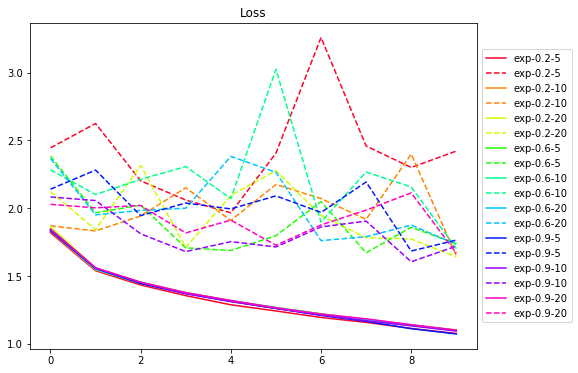

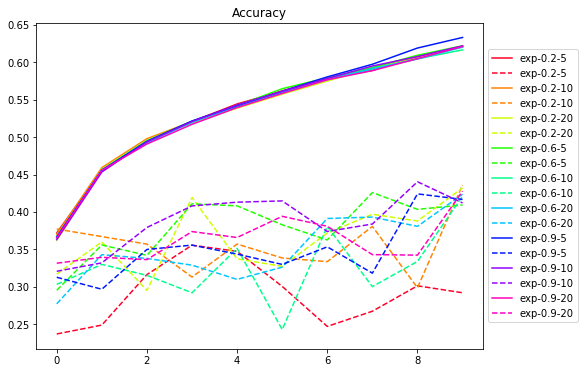

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()